# **Introduction**

สวัสดีครับ นี้เป็นการส่ง Final Project ของ CS434

ทุกๆ วันนี้ 2 พันกว่าล้านแอพให้ผู้ใชได้ดาวโหลด และกว่า 2 ล้านกว่าแอพให้โหลดใน
Google Play Store. แอพพวกนี้ได้มีช่วยในการใช้ชีวติของพวกเราจนถึงทุกวันนี้

วันนี้ผมจะมาลองศึกษาเกี่ยวกับการแนะนำ App ตามคำค้นหาในแต่ละรูปแบบ

# **Table of Contents**

-   [Importing Libraries](#importing)
-   [Importing Dataset](#datasets)
-   [Basic Data Exploration](#basic_understanding)
-   [Data Cleaning](#data_cleaning)
-   [Exploratory Data Analysis](#eda)
-   [Feature Engineering](#feature_engineering)
-   [References](#references)


<a id='importing'></a>

## **Importing libraies**


In [9030]:
# imports
# ref: https://www.kaggle.com/nandalald/android-app-recommendation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import pandas as pd
import numpy as np
import gradio as gr
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')


<a id='dataset' ></a>

## **Dataset**


In [9031]:

file_name = "data/googleplaystore.csv"
df_temp = pd.read_csv(file_name, encoding="utf-8")


<a id='basic_understanding' />


In [9032]:
df_temp.sample(5)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
6731,BS Generator,FAMILY,4.2,5,3.3M,100+,Free,0,Everyone,Entertainment,"July 23, 2016",1.1,4.4 and up
5108,Lakeside AG Moultrie,LIFESTYLE,5.0,3,8.6M,50+,Free,0,Everyone,Lifestyle,"May 23, 2017",1.0,4.1 and up
1167,Discover Mobile,FINANCE,4.6,87951,68M,"5,000,000+",Free,0,Everyone,Finance,"July 23, 2018",9.7.0,4.1 and up
8794,Dr. Booster - Boost Game Speed,TOOLS,4.4,138872,22M,"10,000,000+",Free,0,Everyone,Tools,"May 15, 2018",2.0.1077,4.1 and up
6919,HD Widgets,PERSONALIZATION,4.3,58614,26M,"1,000,000+",Paid,$0.99,Everyone,Personalization,"December 7, 2016",4.3.2,4.4 and up


In [9033]:
# เข้าใจข้อมูล
# check dataset info
df_temp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [9034]:
# check null
df_temp.isna().sum()


App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

_จะเห็นได้ว่า rating มีข้อมูลเสียเยอะ_


<a id='data_cleaning' ></a>

## **Data Cleaning**

> เราจะใช้ข้อมูลที่จำเป็นสำหรับการใช้ข้อมูลนี้เท่านั้น  
> เช็คข้อมูล insight หลักๆ ที่อาจจะทำให้เรามีปัญหาในการใช้ข้อมูล  
> ข้อมูลที่ไม่จำเป็นเราจะนำออกไป เช่น rating, reviews บลาๆ  
>


In [9035]:
df = df_temp.copy()

# remove unuse cols
df = df.reindex(columns=['App', 'Category', 'Size',
                'Type', 'Genres', 'Price', 'Installs', 'Content Rating'])


In [9036]:
# rename col
temp_keys = {}
for i in df.columns:
    temp_keys[i] = i.lower()
df = df.rename(columns=temp_keys)


In [9037]:
df.isna().sum()
# ข้อมูลที่เสียมีน้อยมาก


app               0
category          0
size              0
type              1
genres            0
price             0
installs          0
content rating    1
dtype: int64

In [9038]:
# ลบข้อมูลที่เสียออกไปซะ
df.drop_duplicates(subset='app', inplace=True, ignore_index=True)
df.shape


(9660, 8)

In [9039]:
# เราจะทำการลบข้อมูล ที่เสียหาย
df.dropna(axis=0, inplace=True)
df.isna().sum()


app               0
category          0
size              0
type              0
genres            0
price             0
installs          0
content rating    0
dtype: int64

_ข้อมูลที่เสียหายหมดแล้วว_

#### เช็คแต่ละตารางที่อาจจะมีปัญหา


In [9040]:
df.groupby(['content rating'])['content rating'].count()


content rating
Adults only 18+       3
Everyone           7903
Everyone 10+        321
Mature 17+          393
Teen               1036
Unrated               2
Name: content rating, dtype: int64

_จากข้อมูลชุดนี้ Unrate น่าจะหมายถึง everyone_

#### ทำการเปลี่ยนข้อมูล


In [9041]:
df.loc[df['content rating'] == 'Unrated', ['content rating']] = 'Everyone'

df.groupby(['content rating'])['content rating'].count()


content rating
Adults only 18+       3
Everyone           7905
Everyone 10+        321
Mature 17+          393
Teen               1036
Name: content rating, dtype: int64

_ข้อมูลถูกเปลี่ยนแล้วเย้_


In [9042]:

df.groupby(['category'])['category'].count()


category
ART_AND_DESIGN           64
AUTO_AND_VEHICLES        85
BEAUTY                   53
BOOKS_AND_REFERENCE     222
BUSINESS                420
COMICS                   56
COMMUNICATION           315
DATING                  171
EDUCATION               119
ENTERTAINMENT           102
EVENTS                   64
FAMILY                 1831
FINANCE                 345
FOOD_AND_DRINK          112
GAME                    959
HEALTH_AND_FITNESS      288
HOUSE_AND_HOME           74
LIBRARIES_AND_DEMO       84
LIFESTYLE               369
MAPS_AND_NAVIGATION     131
MEDICAL                 395
NEWS_AND_MAGAZINES      254
PARENTING                60
PERSONALIZATION         376
PHOTOGRAPHY             281
PRODUCTIVITY            374
SHOPPING                202
SOCIAL                  239
SPORTS                  325
TOOLS                   827
TRAVEL_AND_LOCAL        219
VIDEO_PLAYERS           163
WEATHER                  79
Name: category, dtype: int64

In [9043]:

df.loc[df['category'] == '1.9']


,app,category,size,type,genres,price,installs,content rating


> ข้อมูลที่เราพบปัญหานั้น col ไม่ครบ เราเลยจะนำข้อมูลจากตารางหลักมา  
> ข้อมูลจากตารางหลักบางอย่างนั้นไม่มี เช่น Category, Gengre  
> ซึ่งจากที่ดูๆ ข้อมูลเหมาะกับ HOUSE_AND_HOME, House & Home  
> เราเลยจะเปลี่ยนข้อมูลให้กับข้อมูลนี้


In [9044]:
temp_data = df_temp.loc[df_temp['App'] ==
                        'Life Made WI-Fi Touchscreen Photo Frame']
temp_data


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [9045]:
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'type'] = temp_data['Price']
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'size'] = temp_data['Category']
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'price'] = temp_data['Installs']
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'installs'] = temp_data['Size']
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'category'] = 'HOUSE_AND_HOME'
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'genres'] = 'House & Home'

# เพื่อความแน่ใจ ลองเช็คข้อมูลอีกรอบ
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame']


,app,category,size,type,genres,price,installs,content rating


*ข้อมูลได้ถูกเปลี่ยนแล้วเย้*

In [9046]:
# มาดูส่วนของ genres
df.groupby(['genres'])['genres'].count()


genres
Action                                   299
Action;Action & Adventure                 12
Adventure                                 73
Adventure;Action & Adventure               5
Adventure;Brain Games                      1
                                        ... 
Video Players & Editors                  162
Video Players & Editors;Creativity         1
Video Players & Editors;Music & Video      2
Weather                                   79
Word                                      23
Name: genres, Length: 118, dtype: int64

_จะเป็นได้ว่าบาง genres มีมา่กกว่า 1 รูปแบบ ซึ่งแบ่งด้วย ตัว semi colon_  
_เราจะแบ่งตัว genres ให้เป็นรูปแบบ ว่าตัว genres มันมีเท่าไหร่_


In [9047]:

genres = df['genres']
genres_results = {}
for gen in genres:
    for g in gen.split(';'):
        if g not in genres_results:
            genres_results[g] = 1
            continue
        genres_results[g] += 1
genres_results


{'Art & Design': 65,
 'Pretend Play': 69,
 'Creativity': 33,
 'Action & Adventure': 98,
 'Auto & Vehicles': 85,
 'Beauty': 53,
 'Books & Reference': 225,
 'Business': 420,
 'Comics': 56,
 'Communication': 316,
 'Dating': 171,
 'Education': 678,
 'Music & Video': 31,
 'Brain Games': 64,
 'Entertainment': 592,
 'Events': 64,
 'Finance': 345,
 'Food & Drink': 112,
 'Health & Fitness': 290,
 'House & Home': 74,
 'Libraries & Demo': 84,
 'Lifestyle': 370,
 'Adventure': 80,
 'Arcade': 199,
 'Casual': 225,
 'Card': 49,
 'Action': 311,
 'Strategy': 98,
 'Puzzle': 142,
 'Sports': 335,
 'Music': 22,
 'Word': 23,
 'Racing': 108,
 'Simulation': 206,
 'Board': 60,
 'Trivia': 39,
 'Role Playing': 115,
 'Educational': 102,
 'Music & Audio': 1,
 'Video Players & Editors': 165,
 'Medical': 395,
 'Social': 239,
 'Shopping': 202,
 'Photography': 281,
 'Travel & Local': 219,
 'Tools': 827,
 'Personalization': 376,
 'Productivity': 374,
 'Parenting': 60,
 'Weather': 79,
 'News & Magazines': 254,
 'Maps & N

In [9048]:
def convert_size(s):
    if s.replace('M', '').replace('.', '', 1).isdigit():
        size = float(s.replace('M', ''))
        return 1024 * size
    if s.replace('k', '').replace('.', '', 1).isdigit():
        return float(s.replace('k', ''))
    return 0


> จะเห็นได้ว่า size เป็น type object ต้องเปลี่ยนเป็น int  
> ซึ่งเราจะแปลกตัวเลขนี้ ให้เป็นค่า kb ทั้งหมด จะได้ใช้ได้ง่าย เมื่อมีค่าอิน
> นอกจากตัวค่า mb


In [9049]:
df['size'] = df['size'].apply(convert_size)
df['size'].sample(5)


6430      209.0
6855    25600.0
4453    57344.0
5969    18432.0
6817     8499.2
Name: size, dtype: float64

_จะเห็นได้ว่า installs เป็น type object ต้องเปลี่ยนเป็น int_


In [9050]:
df['installs'].sample(2)


5438    10,000+
5394    10,000+
Name: installs, dtype: object

_ข้อมูลจะมี + ตามหลัง และ comma เราจะนำออก; และเปลี่ยนค่าเป็น int32_


In [9051]:
df['installs'] = df['installs'].str.replace(
    '+', '', regex=True).replace(',', '', regex=True).astype(int)
df['installs']


0          10000
1         500000
2        5000000
3       50000000
4         100000
          ...   
9655        5000
9656         100
9657        1000
9658        1000
9659    10000000
Name: installs, Length: 9658, dtype: int32

In [9052]:
# price จะมีสองรูปแบบคือ free กับ paid ต้องเปลี่ยนเป็น bin ถึงจะได้ง่ายต่อการทำงาน

df.loc[df['price'] != "Free", 'price'] = df.loc[df['price']
                                                != "Free", 'price'].apply(lambda x: float(x.replace('$', '')))

df.loc[df['price'] == 'Free', 'price'] = 0

df['price'].sample(5)


994     0.0
8609    0.0
598     0.0
8772    0.0
6282    0.0
Name: price, dtype: float64

<a id='eda'></a>

## **Exploratory Data Analysis**


### ดูประรูปแบบของอายุของแต่ละประเภท

    ดูว่าแต่แอพแต่ละประเภทนั้นมีความนิยมในช่วงอายุไหน


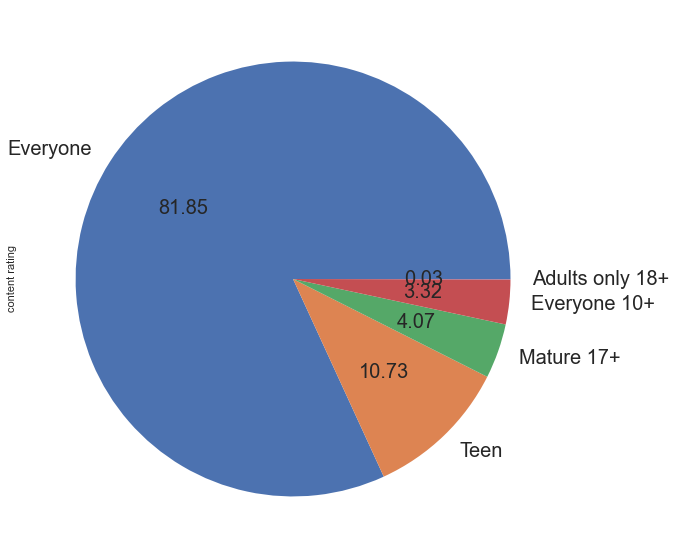

In [9053]:
plt.figure(figsize=(10, 10))
df['content rating'].value_counts().plot(kind='pie', autopct="%.2f",
                                         colors=sns.color_palette("deep"), fontsize=20)
plt.show()


### ดูความนิยมของ 20 อันดับแรกของ แต่ละหมวดหมู่

    ดูว่าแต่แอพแต่ละหมวดหมู่นั้นมีความนิยมเป็นประเภทไหนซะส่วนใหญ่


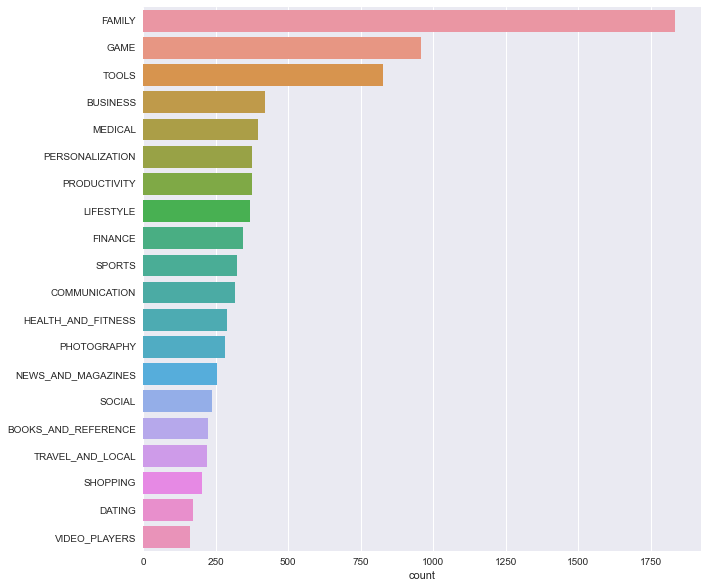

In [9054]:
plt.figure(figsize=(10, 10))
category_dict = dict(df[['category']].groupby(
    'category')['category'].count().nlargest(20))
data_plot = dict(sorted(category_dict.items(),
                 key=lambda kv: kv[1], reverse=True))
data_plot = [key for key, val in data_plot.items() for _ in range(val)]
sns.countplot(y=data_plot)
plt.show()


_แอพหมวดหมู่ FAMILY จะมีเยอะที่สุดใน Google Play Store_


### ดูความนิยมของแต่ละประเภทในแต่ละแอพ

    ดูว่าแต่ละแอพนั้นนิยมประเภทแบบไหนบ้าง


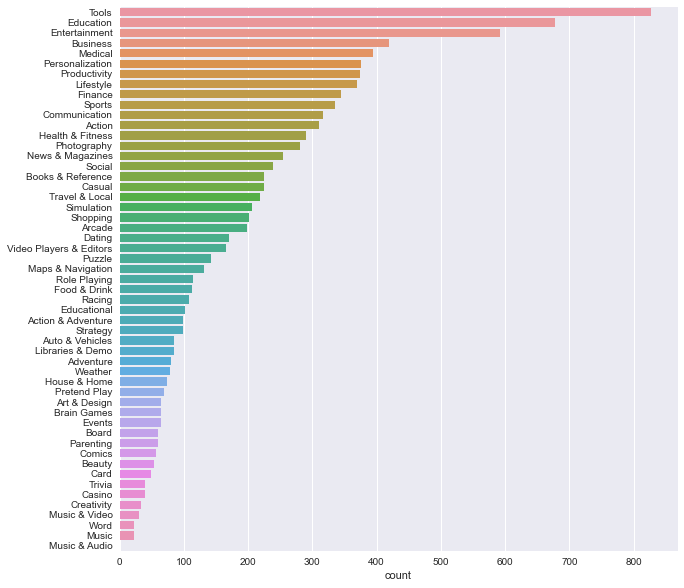

In [9055]:
# ดูความนิยมของแต่ละ tag ในแอพ
plt.figure(figsize=(10, 10))
data_plot = dict(sorted(genres_results.items(),
                 key=lambda kv: kv[1], reverse=True))
data_plot = [key for key, val in data_plot.items() for _ in range(val)]
sns.countplot(y=data_plot)
plt.show()


_แอพประเภท Tools จะมีเยอะที่สุดใน Google Play Store_


### ดูหมวดหมูแต่ละหมวดหมู่ว่า หมวดหมู่ไหนนิยมเสียเงิน

    แสดงหมวดหมูที่นิยมเสียเงิน


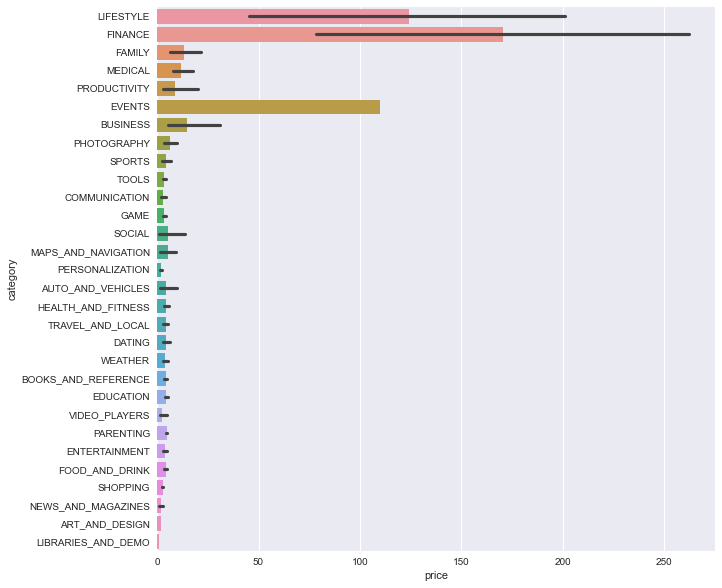

In [9056]:
plt.figure(figsize=(10, 10))
price_sort = df.loc[df.type == 'Paid', ['price', 'category']]
data_plot = dict(price_sort.sort_values(by=['price'], ascending=False))
sns.barplot(data=data_plot, x='price', y='category')
plt.show()


_จะเห็นได้ว่า หมวดหมู่ LIFT STYLE จะแพงที่สุด แต่หมวดหมู่ FINANCE
แอพส่วนใหญ่แน่นเป็นแอพเสียเงิน_


<a id='feature_engineering'></a>

## **Feature Engineering**

#### เราจะทำในเรื่องของ App Recommendation


In [9057]:
df.drop_duplicates(subset=['app'], inplace=True)


In [9058]:
data = df.copy()

describe = (data['genres'].replace(to_replace='(;|&| +)', value=' ',
            regex=True) + " " + data['category'] + " " + data['type'])
data['describe'] = describe

data.head()


,app,category,size,type,genres,price,installs,content rating,describe
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,19456.0,Free,Art & Design,0.0,10000,Everyone,Art Design ART_AND_DESIGN Free
1,Coloring book moana,ART_AND_DESIGN,14336.0,Free,Art & Design;Pretend Play,0.0,500000,Everyone,Art Design Pretend Play ART_AND_DESIGN Free
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,8908.8,Free,Art & Design,0.0,5000000,Everyone,Art Design ART_AND_DESIGN Free
3,Sketch - Draw & Paint,ART_AND_DESIGN,25600.0,Free,Art & Design,0.0,50000000,Teen,Art Design ART_AND_DESIGN Free
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,2867.2,Free,Art & Design;Creativity,0.0,100000,Everyone,Art Design Creativity ART_AND_DESIGN Free


In [9059]:
data.reset_index(drop=True, inplace=True)


In [9060]:
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')


In [9061]:
content_count_matrix = count_vectorizer.fit_transform(data['describe'])
content_count_matrix.shape


(9658, 81)

In [9062]:
type_count_matrix = count_vectorizer.fit_transform(data['genres'].replace(
    to_replace='(;|&| +)', value=' ', regex=True)+data['category'])
type_count_matrix.shape


(9658, 126)

In [9063]:
name_count_matrix = tfidf_vectorizer.fit_transform(
    data['category']+data['app'])
name_count_matrix.shape


(9658, 12342)

In [9064]:
type_cosine_sim = cosine_similarity(type_count_matrix, type_count_matrix)


In [9065]:
content_cosine_sim = cosine_similarity(
    content_count_matrix, content_count_matrix)


In [9066]:
name_cosine_sim = cosine_similarity(name_count_matrix, name_count_matrix)


In [9067]:
class Recommendations:
    def __init__(self, name: str, amount: int = 10):
        self.name = self.nearest_name(name)
        self.amount = amount

    def nearest_name(self, name: str):
        # app_detail = self.get_app_detail(name)

        # if app_detail:
        #     return app_detail
        close = self.get_close_matches(name)
        get_sr = df['app'][df['app'].isin([name])]
        if len(get_sr) != 0:
            return get_sr.iloc[0]
        elif close:
            return close[0]
        return None

    def get_close_matches(self, name: str):
        global df
        get_sr2 = df['app'][df['app'].apply(
            lambda x: x.lower()).str.startswith(name[:2].lower())]
        if len(get_sr2) != 0:
            return get_sr2.tolist()
        return ''

    def get_indices(self):
        metadata = df.reset_index()
        indices = pd.Series(metadata.index, index=metadata['app'])
        if not self.name:
            return None
        return indices[self.name]

    def get_recommendations(self, cosine_sim=content_cosine_sim):
        indice = self.get_indices()
        if not indice:
            return 'No name was near'
        sim_scores = list(enumerate(cosine_sim[indice]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:self.amount + 1]
        _indices = [i[0] for i in sim_scores]
        recs = df[['app', 'genres', 'category', 'type']].iloc[_indices]
        recs['match_score'] = [i[1] for i in sim_scores]
        recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
        return recs.loc[recs.app != self.name, ['app', 'genres', 'category', 'type', 'match_score']]

    def get_app_detail(self):
        return df.loc[df['app'] == self.name, ['app', 'genres', 'category', 'type']]


In [9068]:
recommend = Recommendations('okcupid')
recommend.get_app_detail()


,app,genres,category,type
413,OkCupid Dating,Dating,DATING,Free


In [9069]:
recommend.get_recommendations()


,app,genres,category,type,match_score
412,Zoosk Dating App: Meet Singles,Dating,DATING,Free,1.0
414,Match™ Dating - Meet Singles,Dating,DATING,Free,1.0
415,"Hily: Dating, Chat, Match, Meet & Hook up",Dating,DATING,Free,1.0
416,Hinge: Dating & Relationships,Dating,DATING,Free,1.0
417,Casual Dating & Adult Singles - Joyride,Dating,DATING,Free,1.0
418,BBW Dating & Plus Size Chat,Dating,DATING,Free,1.0
419,"Moco - Chat, Meet People",Dating,DATING,Free,1.0
420,CMB Free Dating App,Dating,DATING,Free,1.0
421,Hot or Not - Find someone right now,Dating,DATING,Free,1.0
422,eharmony - Online Dating App,Dating,DATING,Free,1.0


In [9070]:
recommend.get_recommendations(name_cosine_sim)


,app,genres,category,type,match_score
444,FarmersOnly Dating,Dating,DATING,Free,0.2645
461,SnpCupid Dating,Dating,DATING,Free,0.2645
514,Awake Dating,Dating,DATING,Free,0.2645
522,Geeks Dating,Dating,DATING,Free,0.2645
531,Latin Dating,Dating,DATING,Free,0.2645
541,Toronto Dating,Dating,DATING,Free,0.2645
425,Clover Dating App,Dating,DATING,Free,0.2447
532,Spine- The dating app,Dating,DATING,Free,0.2447
563,Teenage Chat & Dating,Dating,DATING,Free,0.2375
567,SkyLove – Dating and chat,Dating,DATING,Free,0.2375


In [9071]:
recommend.get_recommendations(type_cosine_sim)


,app,genres,category,type,match_score
406,"Moco+ - Chat, Meet People",Dating,DATING,Paid,1.0
407,Calculator,Dating,DATING,Paid,1.0
408,Truth or Dare Pro,Dating,DATING,Paid,1.0
409,"Private Dating, Hide App- Blue for PrivacyHider",Dating,DATING,Paid,1.0
410,Ad Blocker for SayHi,Dating,DATING,Paid,1.0
411,AMBW Dating App: Asian Men Black Women Interra...,Dating,DATING,Paid,1.0
412,Zoosk Dating App: Meet Singles,Dating,DATING,Free,1.0
414,Match™ Dating - Meet Singles,Dating,DATING,Free,1.0
415,"Hily: Dating, Chat, Match, Meet & Hook up",Dating,DATING,Free,1.0
416,Hinge: Dating & Relationships,Dating,DATING,Free,1.0


<a href='deployment'></a>

## **Deployment**


<a href='references'></a>

## **References**

-   <a href="https://www.kaggle.com/ahmedmohamedmahrous/google-play-store-eda-rating-prediction" target="_blank">https://www.kaggle.com/ahmedmohamedmahrous/google-play-store-eda-rating-prediction</a>
-   <a href="https://github.com/MacClay/CS434/blob/main/cs434_finalexam__%E0%B8%AD%E0%B8%B5%E0%B8%AB%E0%B8%A2%E0%B8%B1%E0%B8%87%E0%B8%A7%E0%B8%B0_%E0%B8%AB%E0%B9%89%E0%B8%A7%E0%B8%A2_!_.ipynb" target="_blank">cs434*finalexam\_\_อีหยังวะ*ห้วย*!*</a>
-   <a href="https://www.datacamp.com/community/tutorials/recommender-systems-python" target="_blank">https://www.datacamp.com/community/tutorials/recommender-systems-python</a>

-   <a href="https://www.kaggle.com/lavanyaanandm/recommending-anime-s-using-all-recommendation-sys#10.-Reference-">Anime
    Recommendation</a>

-   <a href="https://stackoverflow.com/a/59444539/15858748">Closest Match</a>

-   <a href="https://stackoverflow.com/questions/28080066/how-to-reference-a-ipython-notebook-cell-in-markdown">How
    to markdown Jupiter Notebook</a>


<a href='members'></a>

## **Members**

-   sad
-   sad
-   sad


In [9072]:

# iface = gr.Interface(get_recommendations, inputs=[gr.inputs.Textbox(label='App Name', default="Santa Fe App")], outputs=[
#                      gr.outputs.Dataframe(label='Your App'), gr.outputs.Dataframe(label='Similar App')])
# iface.launch(debug=True)
